In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from pathlib import Path

In [2]:
PROC = Path("../data/processed/MSFT_clean.csv")
df = pd.read_csv(PROC, parse_dates=["Date"], usecols=['Date','Close','High','Low','Open','Volume'])

In [3]:
df

,Date,Close,High,Low,Open,Volume
0,2017-12-04,74.710899,77.797744,74.360745,77.788528,39094900
1,2017-12-05,75.180824,76.185205,74.618748,74.950463,26152300
2,2017-12-06,76.277328,76.609050,75.033377,75.143953,26162100
3,2017-12-07,76.010117,76.295770,75.558610,76.056192,23184500
4,2017-12-08,77.548943,77.935948,76.784140,77.060570,24489100
...,...,...,...,...,...,...
1955,2025-09-16,509.040009,517.229980,508.600006,516.880005,19711900
1956,2025-09-17,510.019989,511.290009,505.929993,510.619995,15816600
1957,2025-09-18,508.450012,513.070007,507.660004,511.489990,18913700
1958,2025-09-19,517.929993,519.299988,510.309998,510.559998,52371500


In [4]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

In [5]:
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [6]:
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [7]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [8]:
# Average True Range (ATR) - a popular volatility indicator
df['High-Low'] = df['High'] - df['Low']
df['High-Prev_Close'] = np.abs(df['High'] - df['Close'].shift(1))
df['Low-Prev_Close'] = np.abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['High-Low', 'High-Prev_Close', 'Low-Prev_Close']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear

In [9]:
# Create Lag Features for recent days
for i in range(1, 6):  # Create lags for the past 5 days
    df[f'Close_lag_{i}'] = df['Close'].shift(i)
    df[f'Volume_lag_{i}'] = df['Volume'].shift(i)
    df[f'ATR_lag_{i}'] = df['ATR'].shift(i)

# You can also create rolling window features on lagged data
df['SMA_5_lag_1'] = df['SMA_5'].shift(1)
df['EMA_9_lag_1'] = df['EMA_9'].shift(1)

In [10]:
df['Close'] = df['Close'].shift(-1)
df = df.dropna()

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
train_df = df.iloc[:-30].copy()
test_df  = df.iloc[-30:].copy()


In [13]:
df

,Date,Close,High,Low,Open,Volume,EMA_9,SMA_5,SMA_10,SMA_15,...,Volume_lag_3,ATR_lag_3,Close_lag_4,Volume_lag_4,ATR_lag_4,Close_lag_5,Volume_lag_5,ATR_lag_5,SMA_5_lag_1,EMA_9_lag_1
0,2018-01-23,84.607216,85.049542,84.349240,84.680962,23412800,81.416974,82.967038,82.211458,81.415327,...,24159700.0,1.045187,83.059166,25621200.0,1.028733,81.409782,36599700.0,0.934614,82.596619,81.072163
1,2018-01-24,85.077156,86.090745,84.386071,85.279875,33277500,81.752711,83.621274,82.545024,81.806022,...,36875000.0,1.082703,83.022331,24159700.0,1.045187,83.059166,25621200.0,1.028733,82.967038,81.416974
2,2018-01-25,86.671265,85.915669,84.708576,85.206158,26383200,82.045490,83.930884,82.876744,82.166616,...,23601600.0,1.170240,82.930191,36875000.0,1.082703,83.022331,24159700.0,1.045187,83.621274,81.752711
3,2018-01-26,86.542252,86.671265,85.307528,85.805110,29172200,82.355644,84.341849,83.292315,82.533967,...,23412800.0,1.166950,84.413719,23601600.0,1.170240,82.930191,36875000.0,1.082703,83.930884,82.045490
4,2018-01-29,85.454948,87.952064,86.357965,87.666417,31569900,82.796137,85.090063,83.843341,82.960904,...,33277500.0,1.251853,84.680962,23412800.0,1.166950,84.413719,23601600.0,1.170240,84.341849,82.355644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,2025-09-15,509.040009,515.469971,507.000000,508.790009,17143800,505.619790,501.578003,502.802002,503.862004,...,21611800.0,7.079291,498.410004,14410500.0,7.082093,498.200012,16771000.0,7.366803,498.598004,505.144212
1922,2025-09-16,510.019989,517.229980,508.600006,516.880005,19711900,506.593810,505.009998,503.669000,504.404002,...,18881600.0,7.106434,500.369995,21611800.0,7.079291,498.410004,14410500.0,7.082093,501.578003,505.619790
1923,2025-09-17,508.450012,511.290009,505.929993,510.619995,15816600,506.838430,507.135999,504.061002,504.722668,...,23624900.0,7.336432,501.010010,18881600.0,7.106434,500.369995,21611800.0,7.079291,505.009998,506.593810
1924,2025-09-18,517.929993,513.070007,507.660004,511.489990,18913700,507.156585,509.065997,504.528000,505.254667,...,17143800.0,7.650715,509.899994,23624900.0,7.336432,501.010010,18881600.0,7.106434,507.135999,506.838430


In [14]:
cols_to_drop_for_features = ['Date','Close']

y_train = train_df['Close'].copy()
y_test  = test_df['Close'].copy()

X_train = train_df.drop(columns=cols_to_drop_for_features)
X_test  = test_df.drop(columns=cols_to_drop_for_features)


In [15]:
%%time
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb

# Define parameter distributions (consider expanding these ranges)
param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0.01, 0.02, 0.05],
    'random_state': [42]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5) # Using 5 splits is common

# Base model
model = xgb.XGBRegressor(objective='reg:squarederror')

# RandomizedSearchCV with TimeSeriesSplit
clf = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=25,                 # You can increase iterations for a wider search
    scoring='neg_mean_squared_error',
    cv=tscv,                   # Use the time-series cross-validator
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
clf.fit(X_train, y_train)

# Best parameters
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'subsample': 0.8, 'random_state': 42, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.02}
Best validation score = -1611.665790830038
CPU times: total: 5.28 s
Wall time: 31.2 s


In [16]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


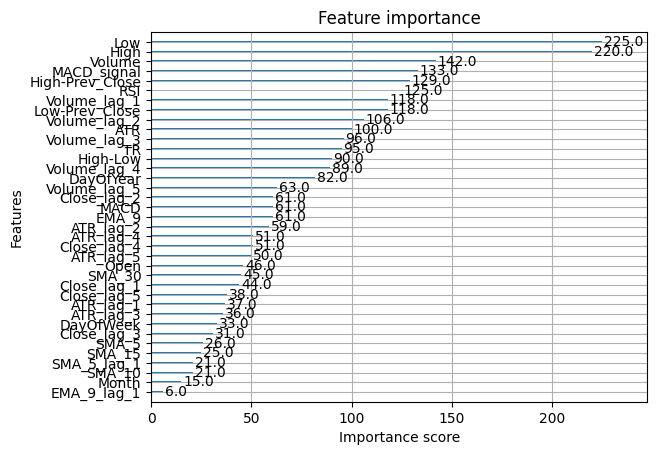

In [17]:
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [18]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [520.91369629 528.37139893 519.72564697 521.62249756 519.31628418]
y_pred = [519.0519  520.21454 521.60315 519.41046 518.29034]


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE = {mae}')
print(f'RMSE = {rmse}')

MAE = 5.43855183919271
RMSE = 6.484647682098121


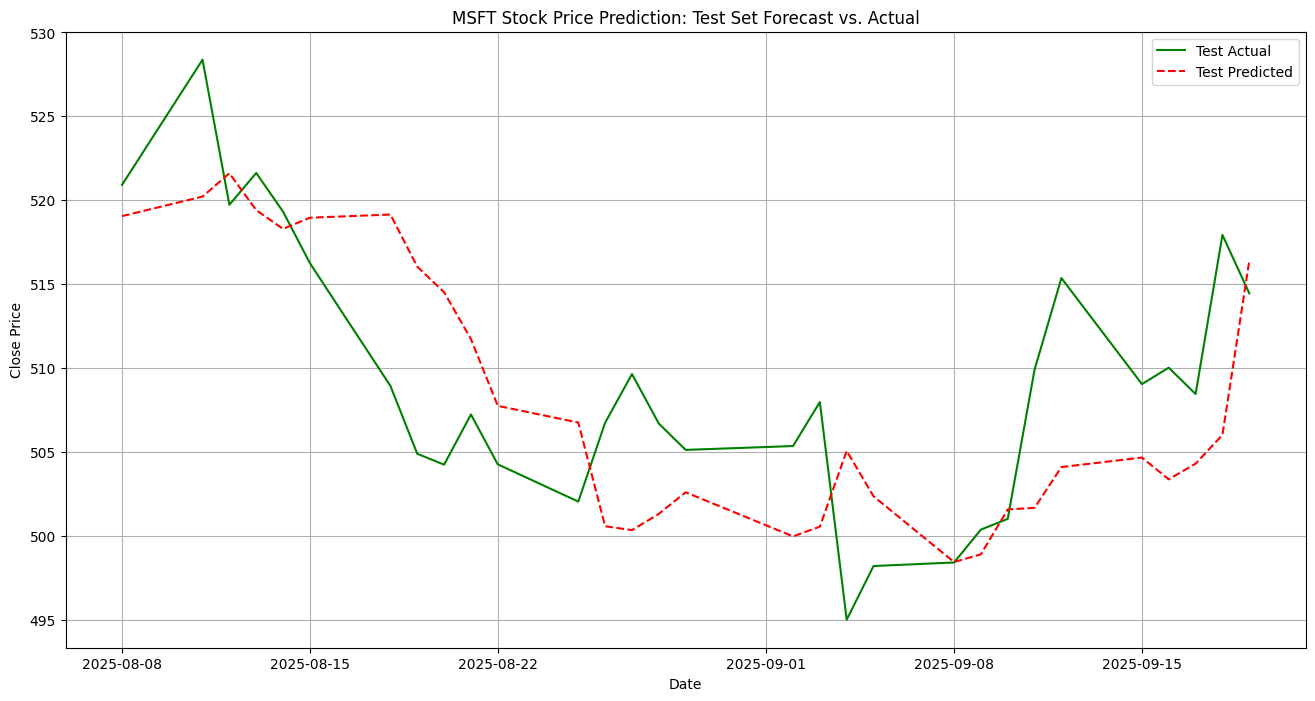

In [21]:
predictions_df = test_df[['Date']].copy()
predictions_df['predicted_close'] = y_pred
predictions_df['actual_close'] = y_test.values

# Plot the test data's actual and predicted close prices
plt.figure(figsize=(16, 8))
plt.plot(predictions_df['Date'], predictions_df['actual_close'], label='Test Actual', color='green')
plt.plot(predictions_df['Date'], predictions_df['predicted_close'], label='Test Predicted', color='red', linestyle='--')

# Add titles and labels for clarity
plt.title('MSFT Stock Price Prediction: Test Set Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()